Importação de Bibliotecas Utilizadas

In [48]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib

import sys
import os

# adiciona a pasta 'scr' ao sys.path
sys.path.append(os.path.abspath("../src"))

from pre_processamento import preprocess_dataframe, clean_text

Carregamento e Inspeção Inicial dos Dados

In [21]:
columns = ['id','subject','sentiment','text']
df = pd.read_csv('../data/raw/twitter_training.csv', names = columns)
df.head()

,id,subject,sentiment,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [22]:
df = preprocess_dataframe(df, text_col="text", label_col='sentiment')
df.head()

,text,text_clean,sentiment
0,im getting on borderlands and i will murder yo...,im getting borderland murder,Positive
1,I am coming to the borders and I will kill you...,coming border kill,Positive
2,im getting on borderlands and i will kill you ...,im getting borderland kill,Positive
3,im coming on borderlands and i will murder you...,im coming borderland murder,Positive
4,im getting on borderlands 2 and i will murder ...,im getting borderland murder,Positive


Vetorização dos Textos e Treinamento do Modelo

In [12]:
le = LabelEncoder()
df['sentiment'] = le.fit_transform(df['sentiment'])
df['sentiment']

0        3
1        3
2        3
3        3
4        3
        ..
74677    3
74678    3
74679    3
74680    3
74681    3
Name: sentiment, Length: 74682, dtype: int64

In [24]:
X = df['text_clean'].astype(str)
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features = 20000, ngram_range = (1,2))),
    ('clf', LogisticRegression(max_iter = 1000, class_weight = 'balanced'))
])

params = {
    'tfidf__max_df': [0.9, 0.95],
    'clf__C': [0.1, 1, 10]
}

grip = GridSearchCV(pipeline, params, cv = 3, n_jobs = -1, scoring = 'f1_macro')
grip.fit(X_train, y_train)

best = grip.best_estimator_
y_pred = best.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  Irrelevant       0.80      0.80      0.80      2598
    Negative       0.89      0.84      0.86      4509
     Neutral       0.76      0.83      0.79      3664
    Positive       0.85      0.83      0.84      4166

    accuracy                           0.83     14937
   macro avg       0.82      0.82      0.82     14937
weighted avg       0.83      0.83      0.83     14937



Matriz de Confusão

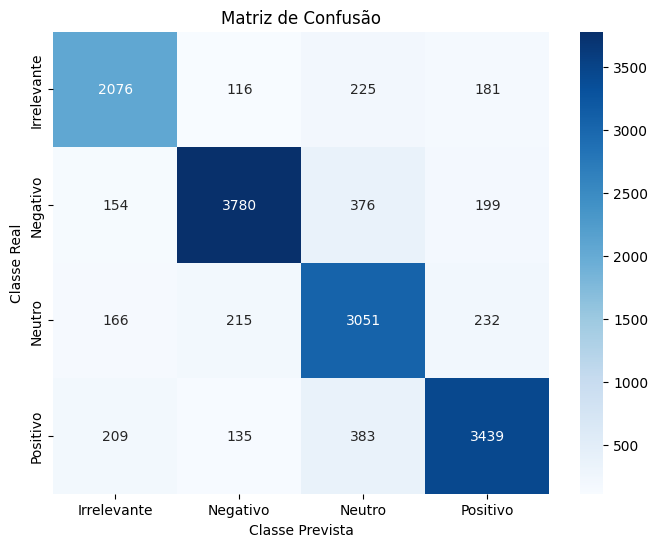

In [33]:
# Supondo y_test e y_pred já definidos
cm = confusion_matrix(y_test, y_pred)

nomes_amigaveis = ['Irrelevante', 'Negativo', 'Neutro', 'Positivo']

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=nomes_amigaveis, yticklabels=nomes_amigaveis)
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Real')
plt.title('Matriz de Confusão')
# Salvar imagem do gráfico
plt.savefig(r'../assets/matriz_confusao.png')
plt.show()

Curva ROX Multi-classe

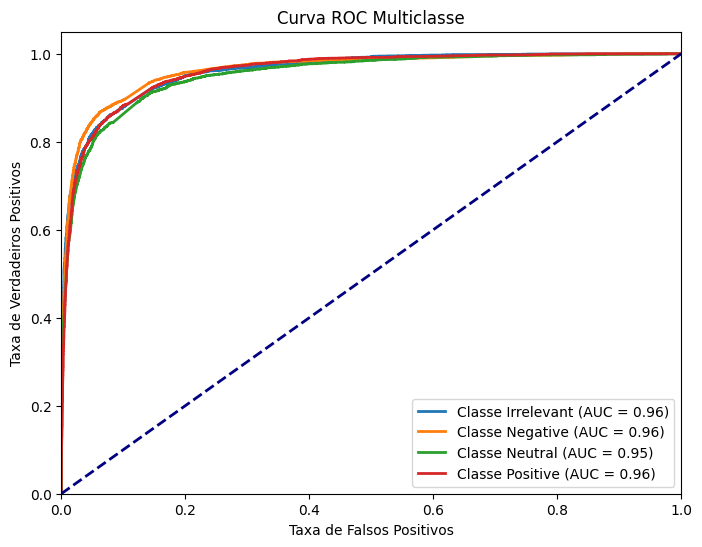

In [46]:
classes = np.unique(y_test)

# Binariza os rótulos (0/1) para cada classe
y_test_bin = label_binarize(y_test, classes=classes)

# Probabilidades previstas pelo modelo
y_score = grip.predict_proba(X_test)  # shape = [n_amostras, n_classes]

# Plotando a ROC para cada classe
plt.figure(figsize=(8,6))
for i, classe in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Classe {classe} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC Multiclasse')
plt.legend(loc='lower right')
# Salvar imagem do gráfico
plt.savefig(r'../assets/curva_ROC.png')
plt.show()


Salvando Modelo Treinado

In [51]:
joblib.dump(best, "../models/modelo_sentimento.pkl")

['../models/modelo_sentimento.pkl']